In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cwd = os.getcwd()

ROOT = os.path.join(cwd, '../../')
DATA_FOLDER = os.path.join(ROOT, 'data/')

In [3]:
colab = False
if colab:
    df = pd.read_pickle('saeb_pb_2017-2007_fe.pkl')
else:
    df = pd.read_pickle(os.path.join(DATA_FOLDER, 'saeb_pb_2017-2007_fe.pkl'))
df = df.dropna()
print(len(df))
df.head()

232882


,desempenho_aluno_cat,faz_licao_casa_2.0,reprovacao_0.0,reprovacao_1.0,pai_sabe_ler_escrever_1.0,leitura_revista_comportamento_0.0,leitura_jornais_0.0,escolaridade_pai_4.0,mae_sabe_ler_escrever_1.0,leitura_internet_2.0,tempo_lazer_1.0,escolaridade_mae_4.0,gosta_estudar_disciplina_0.0,gosta_estudar_disciplina_1.0,desempenho_aluno,id_aluno,disciplina,proficiencia,erro_padrao
8086,2,True,True,False,False,True,True,False,True,True,True,False,False,True,Proficiente,23061434,LP,0.665701,0.312872
10602,0,True,False,True,True,False,False,False,False,True,True,False,False,True,Insuficiente,23065563,LP,-1.353424,0.484866
13975,0,True,False,True,True,False,False,False,False,True,True,False,False,True,Insuficiente,23065563,MT,-1.652930,0.564617
17847,0,True,True,False,False,False,False,False,True,False,False,False,False,True,Insuficiente,23065552,MT,-1.099605,0.467812
20664,0,False,False,True,True,False,False,False,True,True,False,False,True,False,Insuficiente,23095249,MT,-1.262341,0.512487


In [4]:
exclude = ['ano', 'sigla_uf', 'id_aluno', 'situacao_censo', 'disciplina', 'proficiencia', 'erro_padrao', 'proficiencia_saeb',
       'erro_padrao_saeb', 'sexo', 'raca_cor','ano_nascimento', 'rede', 'id_escola', 'serie', 'turno', 'escola_publica', 'desempenho_aluno']

exclude = [col for col in df.columns if col in exclude]

In [5]:
# print unique values for each column

for col in df.columns:
    if col not in exclude:
        print(col, df[col].unique())

desempenho_aluno_cat [2 0 3 1]
faz_licao_casa_2.0 [ True False]
reprovacao_0.0 [ True False]
reprovacao_1.0 [False  True]
pai_sabe_ler_escrever_1.0 [False  True]
leitura_revista_comportamento_0.0 [ True False]
leitura_jornais_0.0 [ True False]
escolaridade_pai_4.0 [False  True]
mae_sabe_ler_escrever_1.0 [ True False]
leitura_internet_2.0 [ True False]
tempo_lazer_1.0 [ True False]
escolaridade_mae_4.0 [False  True]
gosta_estudar_disciplina_0.0 [False  True]
gosta_estudar_disciplina_1.0 [ True False]


In [6]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype(int)
y = y.astype(int)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


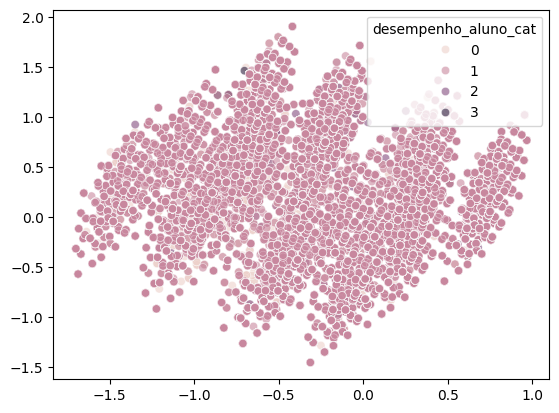

In [7]:
# plotting pca

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.6)
plt.show()

# binary + under sampling (dropping 'Básico' + 'Insuficiente')

In [28]:
_df = df.copy()
_df = _df[_df['desempenho_aluno_cat'] != 1]
_df = _df[_df['desempenho_aluno_cat'] != 2]

In [29]:
X = _df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = _df['desempenho_aluno_cat']

X = X.astype(int)
y = y.astype(int)

y = np.where(y == 0, 0, 1)

In [30]:

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2645, 2689]))

In [33]:


clf = SVC(kernel='rbf', gamma=0.001, C=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       689
           1       0.76      0.85      0.80       645

    accuracy                           0.80      1334
   macro avg       0.80      0.80      0.80      1334
weighted avg       0.80      0.80      0.80      1334



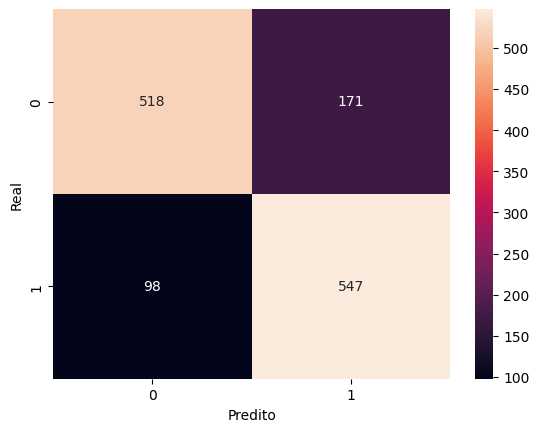

In [34]:
# matriz de confusão do seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [35]:
# acurácia
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')

Acurácia: 0.7983508245877061


In [16]:
# training the model on training set


param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
grid = GridSearchCV(estimator=SVC(kernel='rbf', decision_function_shape='ovo'), param_grid=param_grid, cv=5)

%time grid.fit(X_train, y_train)
print(grid.best_params_)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: user 2min 36s, sys: 559 ms, total: 2min 37s
Wall time: 2min 42s
{'C': 10, 'gamma': 0.001}


# multiclass + under sampling

In [36]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype(int)
y = y.astype(int)

In [37]:
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3]), array([2661, 2682, 2628, 2697]))

In [40]:
clf = SVC(kernel='rbf', gamma=0.1, C=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.59      0.52       673
           1       0.30      0.23      0.26       652
           2       0.30      0.19      0.23       706
           3       0.41      0.58      0.48       637

    accuracy                           0.39      2668
   macro avg       0.37      0.40      0.37      2668
weighted avg       0.37      0.39      0.37      2668



In [22]:
param_grid = {'C': [1, 5, 10, 50],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
grid = GridSearchCV(estimator=SVC(kernel='rbf', decision_function_shape='ovo'), param_grid=param_grid, cv=5)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 20min 21s, sys: 1.58 s, total: 20min 22s
Wall time: 20min 43s
{'C': 1, 'gamma': 0.1}


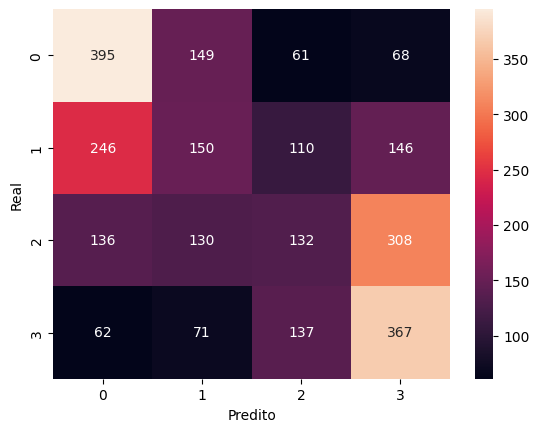

In [41]:
# matriz de confusão do seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [42]:
# acurácia
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')

Acurácia: 0.391304347826087
